In [1]:
import os, shutil
from os import walk
import tensorflow as tf
from keras import models, layers, optimizers, regularizers, callbacks, preprocessing
from keras.applications import VGG16, Xception
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# Load the dataframes holding the image paths and classes

datadir = '/home/biniyam.yohannes/dlproject/data/201/'
labels_dir = '/home/biniyam.yohannes/dlproject/train_data_201.csv'
data = pd.read_csv(labels_dir)
data

,Path,Class
0,/home/biniyam.yohannes/dlproject/data/201/clos...,closet
1,/home/biniyam.yohannes/dlproject/data/201/brid...,bridge
2,/home/biniyam.yohannes/dlproject/data/201/ski_...,ski_slope
3,/home/biniyam.yohannes/dlproject/data/201/boar...,boardwalk
4,/home/biniyam.yohannes/dlproject/data/201/badl...,badlands
...,...,...
1499995,/home/biniyam.yohannes/dlproject/data/201/clas...,classroom
1499996,/home/biniyam.yohannes/dlproject/data/201/viad...,viaduct
1499997,/home/biniyam.yohannes/dlproject/data/201/boat...,boat_deck
1499998,/home/biniyam.yohannes/dlproject/data/201/pond...,pond


In [3]:
input_shape = (224, 224, 3)
classes = 201
batch_size = 256

In [4]:
# Define a generator

img_datagen = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=True,
        samplewise_std_normalization=True,
)

In [5]:
# A function to select random batches of data from the dataset

def get_random_batch(sample_size):
    data_sample = data.sample(n=sample_size)
    
    train_generator = img_datagen.flow_from_dataframe(
        data_sample, color_mode="rgb", x_col="Path", y_col="Class",
        target_size=(224, 224), class_mode="categorical",
        subset="training",batch_size=batch_size)
    steps_per_epoch = len(train_generator)
    
    # Recommend to convert generator to tf.data.Dataset for mirroredstrategy use.
    train_data = tf.data.Dataset.from_generator(
         lambda: train_generator,
         output_types=(tf.float32, tf.float32),
         output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], # Image Shape
                        [None, classes]))                                       # Label Shape
    
    train_data_c = train_data.cache()
    
    return train_data_c, steps_per_epoch

In [6]:
# # Model 1 - VGG16

# def get_model():
#     conv_base = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape)
#     conv_base.trainable = False

#     model = models.Sequential()
#     model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(classes, activation='relu'))  # did you mean to have 'classes' neurons in this layer?
#     model.add(layers.Dense(classes, activation='softmax'))
    
#     return model

In [7]:
# # Model 2 - VGG16 + Fine-tuning

# def get_model():
    
#     conv_base = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape)
    
#     set_trainable = False
    
#     for layer in conv_base.layers:
#         if layer.name == 'block5_conv1':
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

#     model = models.Sequential()
#     model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1024, activation='relu'))
#     model.add(layers.Dense(classes, activation='softmax'))
    
#     return model

In [6]:
#Model 3 - Xception

def get_model():
    conv_base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)
    conv_base.trainable = False

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(classes, activation='relu'))  # did you mean to have 'classes' neurons in this layer?
    model.add(layers.Dense(classes, activation='softmax'))
    
    return model

In [7]:
# A function to train a given model

def train_model(epochs, sample_size, checkpoints_path):
    train_batch, steps = get_random_batch(sample_size)
    epoch = 1
    for _ in range(epochs):
        print("Epochs: {}/{}".format(epoch, epochs))
        epoch += 1
        model.fit(
            train_batch,
            epochs=1,
            steps_per_epoch=steps
        )
        model.save(checkpoints_path)

In [8]:
# Set up tensorflow mirrored strategy to split batches among virtual gpus.

strategy = tf.distribute.MirroredStrategy(
     # devices=["/gpu:0"], # ,"/gpu:1", "/gpu:2", "/gpu:3"
     # cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()
)

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [9]:
# Select if you want to continue training an existing model or define a new one

model_path = "/home/biniyam.yohannes/dlproject/xception_checkpoint"

with strategy.scope():
    if os.path.exists(model_path):
        model = models.load_model(model_path)
        print("Previous Model Loaded.")
    else:
        model = get_model()

        model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=0.001),
            metrics=['accuracy',
                     tf.keras.metrics.TopKCategoricalAccuracy(
                         k=5, name="top_5_acc")])
        
        print("New Model Created.")

model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Compile the model

with strategy.scope():
    model.compile(
                loss='categorical_crossentropy',
                optimizer=optimizers.SGD(lr=0.0001, momentum = .9),
                metrics=['accuracy',
                         tf.keras.metrics.TopKCategoricalAccuracy(
                             k=5, name="top_5_acc")])

# Set Up Validation

In [11]:
# A function to select random batches of data and prepare it for validation

def get_validation_sample_acc(sample_size):
    valid_data_sample = valid_data_df.sample(n=sample_size, random_state = 47)
    
    valid_generator = img_datagen.flow_from_dataframe(
        valid_data_sample, color_mode="rgb", x_col="Path", y_col="Class",
        target_size=(224, 224), class_mode="categorical",batch_size=batch_size)
    valid_steps = len(valid_generator)
    
    valid_data = tf.data.Dataset.from_generator(
     lambda: valid_generator,
     output_types=(tf.float32, tf.float32),
     output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], # Image Shape
                    [None, classes]))                                       # Label Shape
    
    val_eval = model.evaluate(valid_data, steps=valid_steps)
    
    return val_eval[1] # accuracy

In [12]:
# Import the validation data and convert it into a dataframe

valid_dir = '/home/biniyam.yohannes/dlproject/valid_data_201.csv'
valid_data_df = pd.read_csv(valid_dir)
valid_data_df

,Path,Class
0,/home/biniyam.yohannes/dlproject/data/201/swim...,swimming_pool
1,/home/biniyam.yohannes/dlproject/data/201/camp...,campsite
2,/home/biniyam.yohannes/dlproject/data/201/phon...,phone_booth
3,/home/biniyam.yohannes/dlproject/data/201/hote...,hotel
4,/home/biniyam.yohannes/dlproject/data/201/cour...,courtyard
...,...,...
499995,/home/biniyam.yohannes/dlproject/data/201/lobb...,lobby
499996,/home/biniyam.yohannes/dlproject/data/201/moun...,mountain
499997,/home/biniyam.yohannes/dlproject/data/201/fire...,fire_station
499998,/home/biniyam.yohannes/dlproject/data/201/snow...,snowfield


In [13]:
# Calculate validation accuracy on a sample with size 20000

get_validation_sample_acc(20000)

Found 20000 validated image filenames belonging to 201 classes.
79/79 [==============================] - 50s 511ms/step - loss: 2.2518 - accuracy: 0.4415 - top_5_acc: 0.7446


0.4458500146865845

# Training Loop

In [14]:
# Train the model on 15 random data batches, with 10 epochs for every batch 

%%notify
best_path = "/home/biniyam.yohannes/dlproject/xception_model_best"
checkpoints_path = "/home/biniyam.yohannes/dlproject/xception_checkpoint"
epochs_per_batch = 10
batches = 15
batch_sample_size = 102400
valid_sample_size = 20000
best_acc = .43

for _ in range(batches):
    batch = 1
    print("Batches: {}/{}".format(batch, batches))
    batch += 1
    train_model(epochs_per_batch, batch_sample_size, checkpoints_path)
    val_acc = get_validation_sample_acc(valid_sample_size)
    print("Val Accuracy: {:10.4}".format(val_acc))
    if (val_acc-best_acc) > .005:
        best_acc = val_acc
        model.save(best_path)
    else:
        break

Batches: 1/15
Found 102400 validated image filenames belonging to 201 classes.
Epochs: 1/10
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
400/400 [==============================] - 959s 2s/step - loss: 2.0771 - accuracy: 0.4853 - top_5_acc: 0.7683
INFO:tensorflow:Assets written to: /home/biniyam.yohannes/dlproject/xception_checkpoint/assets
Epochs: 2/10
400/400 [==============================] - 319s 796ms/step - loss: 2.0652 - accuracy: 0.4864 - top_5_acc: 0.7708
INFO:tensorflow:Assets written to: /home/biniyam.yohannes/dlproject/xception_checkpoint/assets
Epochs: 3/10
400/400 [==============================] - 317s 792ms/step - loss: 2.0587 - accuracy: 0.4866 - top_5_acc: 0.7706
INFO:tensorflow:Assets written to: /home/biniyam.yohannes/dlproject/xception_checkpoint/assets
Epochs: 4/10
400/400 [==============================] - 319s 796ms/step - loss: 2.0463 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [22]:
save_path = "/home/biniyam.yohannes/dlproject/models/xception_model"
model.save(save_path)

INFO:tensorflow:Assets written to: /home/biniyam.yohannes/dlproject/models/xception_model/assets


# Predictions

In [26]:
# Define and sort the class label names

class_labels = ['cockpit', 'corn_field', 'supermarket', 'igloo', 'swamp', 'restaurant_kitchen', 'iceberg', 'botanical_garden', 'campsite', 'chalet', 'engine_room', 'attic', 'veranda', 'food_court', 'aqueduct', 'medina', 'pond', 'yard', 'valley', 'forest_path', 'beauty_salon', 'ice_skating_rink', 'music_studio', 'candy_store', 'ski_resort', 'herb_garden', 'banquet_hall', 'market', 'hotel_room', 'bridge', 'mansion', 'watering_hole', 'butchers_shop', 'shopfront', 'swimming_pool', 'home_office', 'schoolhouse', 'bakery', 'classroom', 'amphitheater', 'doorway', 'aquarium', 'cafeteria', 'forest_road', 'hospital', 'excavation', 'conference_center', 'kindergarden_classroom', 'parking_lot', 'windmill', 'hotel', 'pulpit', 'parlor', 'playground', 'raft', 'gas_station', 'kitchenette', 'butte', 'kitchen', 'rice_paddy', 'boat_deck', 'courthouse', 'kasbah', 'train_station', 'highway', 'rainforest', 'staircase', 'corridor', 'conference_room', 'creek', 'water_tower', 'desert', 'art_studio', 'ice_cream_parlor', 'wheat_field', 'reception', 'building_facade', 'plaza', 'canyon', 'hospital_room', 'coffee_shop', 'bus_interior', 'driveway', 'basement', 'bayou', 'sandbar', 'palace', 'snowfield', 'bamboo_forest', 'marsh', 'islet', 'underwater', 'office_building', 'fountain', 'motel', 'shed', 'subway_station', 'crevasse', 'dining_room', 'hot_spring', 'residential_neighborhood', 'sea_cliff', 'restaurant_patio', 'runway', 'ballroom', 'field', 'racecourse', 'castle', 'laundromat', 'pasture', 'dam', 'volcano', 'fire_escape', 'clothing_store', 'track', 'inn', 'viaduct', 'vegetable_garden', 'sky', 'nursery', 'jail_cell', 'ocean', 'stage', 'alley', 'assembly_line', 'bowling_alley', 'living_room', 'patio', 'martial_arts_gym', 'temple', 'topiary_garden', 'church', 'shoe_shop', 'boxing_ring', 'galley', 'game_room', 'pagoda', 'orchard', 'waiting_room', 'shower', 'courtyard', 'slum', 'gift_shop', 'ski_slope', 'arch', 'formal_garden', 'crosswalk', 'train_railway', 'mountain', 'rope_bridge', 'restaurant', 'golf_course', 'cathedral', 'amusement_park', 'stadium', 'dorm_room', 'garbage_dump', 'railroad_track', 'closet', 'bar', 'monastery', 'picnic_area', 'boardwalk', 'airport_terminal', 'auditorium', 'lobby', 'dock', 'apartment_building', 'basilica', 'fairway', 'mountain_snowy', 'bedroom', 'ruin', 'skyscraper', 'coast', 'harbor', 'trench', 'mausoleum', 'phone_booth', 'pavilion', 'museum', 'rock_arch', 'lighthouse', 'art_gallery', 'locker_room', 'dinette', 'pantry', 'television_studio', 'abbey', 'river', 'wind_farm', 'fire_station', 'construction_site', 'tower', 'baseball_field', 'cemetery', 'tree_farm', 'bookstore', 'cottage_garden', 'office', 'badlands']
class_labels.sort()

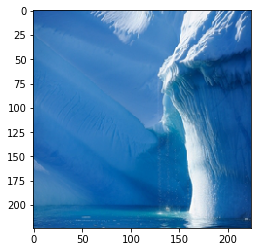

In [27]:
# Import and show an example image

img = preprocessing.image.load_img(
    "/home/biniyam.yohannes/dlproject/data/201/ocean/ocean&4655.jpg",
    color_mode='rgb', target_size=(224,224)
)
plt.imshow(img)

In [28]:
# Predict the label of the image

img_array = preprocessing.image.img_to_array(img)
img_datagen.standardize(img_array)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

prediction = model.predict(img_array)

In [29]:
# Sort and select the the top-5 preidctions

top_5 = sorted(range(len(prediction[0])), key=lambda i: prediction[0][i], reverse=True)[:5]

In [30]:
# Print the top-5 predictions

for i in top_5:
    print(class_labels[i])
    print("Probability: {:10.4}%".format(prediction[0][i]*100))

iceberg
Probability:      96.78%
ocean
Probability:      1.041%
sea_cliff
Probability:     0.4908%
islet
Probability:     0.3868%
harbor
Probability:     0.3075%


# Test Evaluation

In [16]:
# Test the performance on the test dataset

test_dir = '/home/biniyam.yohannes/dlproject/test_data_201.csv'
test_data_df = pd.read_csv(test_dir)
test_data_df

,Path,Class
0,/home/biniyam.yohannes/dlproject/data/201/rain...,rainforest
1,/home/biniyam.yohannes/dlproject/data/201/pavi...,pavilion
2,/home/biniyam.yohannes/dlproject/data/201/rail...,railroad_track
3,/home/biniyam.yohannes/dlproject/data/201/cour...,courtyard
4,/home/biniyam.yohannes/dlproject/data/201/rail...,railroad_track
...,...,...
457078,/home/biniyam.yohannes/dlproject/data/201/fore...,forest_path
457079,/home/biniyam.yohannes/dlproject/data/201/wait...,waiting_room
457080,/home/biniyam.yohannes/dlproject/data/201/mark...,market
457081,/home/biniyam.yohannes/dlproject/data/201/fore...,forest_path


In [17]:
# Prepare the test dataset

test_data_sample = test_data_df.sample(n=20000, random_state=47)

test_generator = img_datagen.flow_from_dataframe(
    test_data_sample, color_mode="rgb", x_col="Path", y_col="Class",
    target_size=(224, 224), class_mode="categorical",batch_size=batch_size)
test_steps = len(test_generator)

test_data = tf.data.Dataset.from_generator(
 lambda: test_generator,
 output_types=(tf.float32, tf.float32),
 output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], # Image Shape
                [None, classes]))                                       # Label Shape

Found 20000 validated image filenames belonging to 201 classes.


In [24]:
# Select the basic VGG-16 model and evaluate its performance 

model_path = "/home/biniyam.yohannes/dlproject/models/VGG16_pretrained_model"

with strategy.scope():
    model = models.load_model(model_path)
    
model.evaluate(test_data, steps=test_steps)

79/79 [==============================] - 44s 534ms/step - loss: 2.3404 - accuracy: 0.4345 - top_5_acc: 0.7537


[2.3403780460357666, 0.4345000088214874, 0.7537000179290771]

In [19]:
# Select the fine-tuned VGG-16 model and evaluate its performance 

model_path = "/home/biniyam.yohannes/dlproject/models/VGG16_finetuned_model"

with strategy.scope():
    model = models.load_model(model_path)
    
model.evaluate(test_data, steps=test_steps)

79/79 [==============================] - 47s 514ms/step - loss: 2.2848 - accuracy: 0.4152 - top_5_acc: 0.7336


[2.284799337387085, 0.41519999504089355, 0.7335500121116638]

In [23]:
# Select the basic Xception model and evaluate its performance 

model_path = "/home/biniyam.yohannes/dlproject/models/xception_model"

with strategy.scope():
    model = models.load_model(model_path)
    
model.evaluate(test_data, steps=test_steps)

79/79 [==============================] - 46s 533ms/step - loss: 2.1762 - accuracy: 0.4508 - top_5_acc: 0.7561


[2.176243305206299, 0.45080000162124634, 0.7560999989509583]